# 캐글 타이타닉 생존자 예측

## 기본 설정

In [456]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [457]:
import sys
assert sys.version_info >= (3, 7)

In [458]:
import sklearn
assert sklearn.__version__ >= "1.0.1"

## 데이터 다운로드와 적재

In [459]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')

`head()`를 사용해 각 데이터의 내용을 확인해보자.



In [460]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [461]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### 데이터셋 기본 정보 확인

In [462]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### 범주형 특성 탐색

`Dtype`에 `object`를 자료형으로 갖는 특성은 범주형 특성이다.

In [463]:
train_data["Name"].value_counts()

Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: Name, Length: 891, dtype: int64

In [464]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [465]:
train_data["Ticket"].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

In [466]:
train_data["Cabin"].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

In [467]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

나머지는 전부 수치형 특성들이다.

In [468]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### 결측치 확인

<AxesSubplot:>

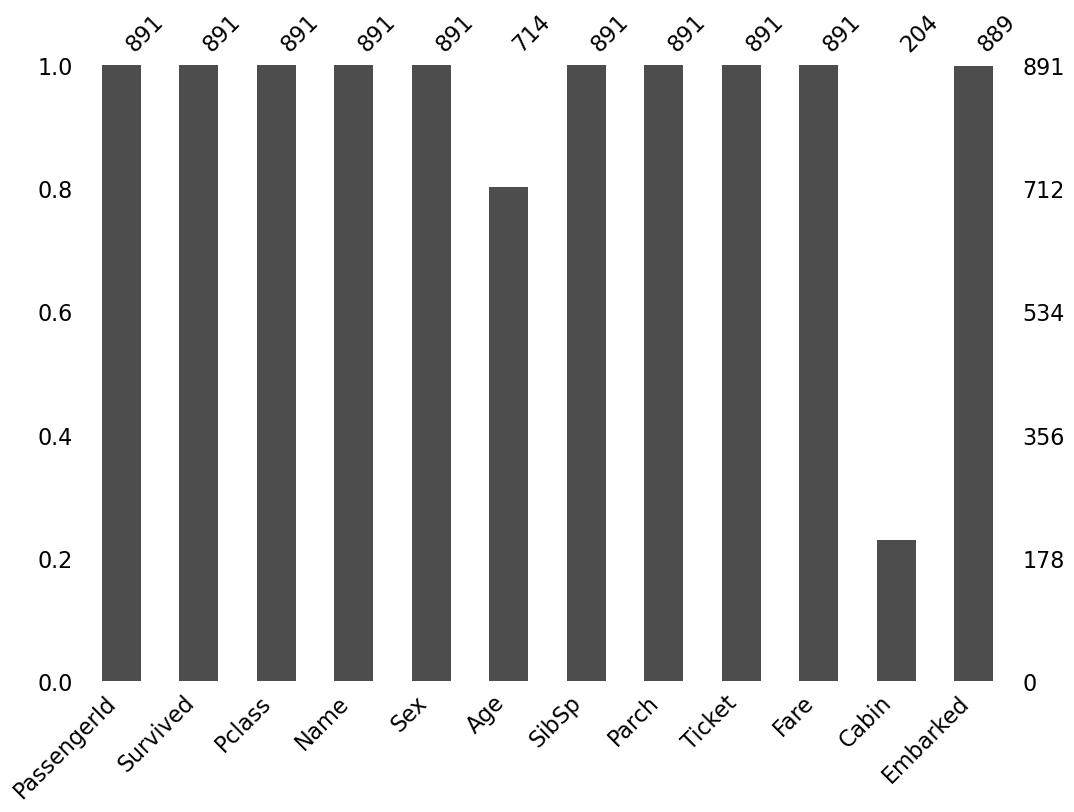

In [469]:
msno.bar(df=train_data.iloc[:, :], figsize=(12, 8), color=(0.3, 0.3, 0.3))

`Age` 특성에서는 결측치를 채워줄 것이고 `Cabin` 특성은 결측치가 너무 많은 관계로 고려하지 않을 것이다.

### 그래프 기본 설정

In [470]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

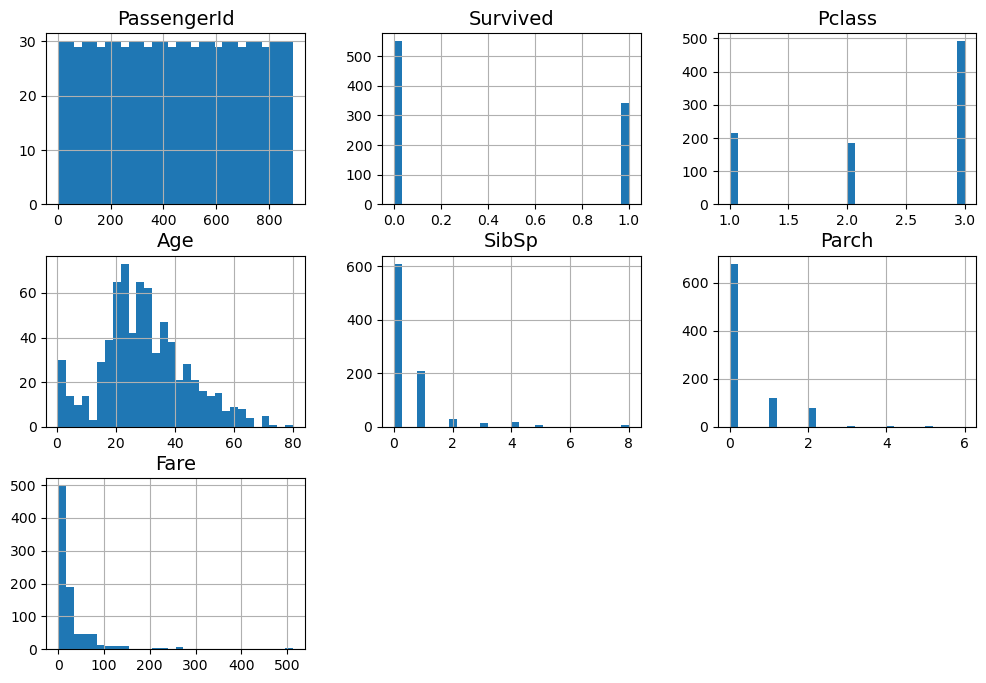

In [471]:
train_data.hist(bins=30, figsize=(12, 8))
plt.show()

캐글에서 제공되는 `Data Dictionay`를 통해 변수명의 의미를 알아보자.

|Variable|Definition|Key|
|------|---|---|
|survival|Survival|0 = No, 1 = Yes|
|pclass|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd|
|sex|Sex||\
|Age|Age in years|
|sibsp|# of siblings / spouses aboard the Titanic|
|parch|# of parents / children aboard the Titanic|
|ticket|Ticket number|
|fare|Passenger fare|
|cabin|Cabin number|
|embarked|Port of Embarkatoin|C = Cherbourg, Q = Queenstown, S = Southampton|

__Variable Notes__
__Pclass__: A proxy for socio-economic status (SES) 1st = Upper 2nd = Middle 3rd = Lower

__Age__: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

__SibSp__: The dataset defines family relations in this way…
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

__Parch__: The dataset defines family relations in this way…
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

특성들의 의미를 알아보자.

- survival: 생존 여부(0은 생존하지 못함, 1은 생존)

- pclass: 사회 경제적 지위(1st = 높음, 2nd = 중간, 3rd = 낮음)

- sex: 성별

- Age: 나이(나이가 1보다 작으면 분수이다. xx.5의 형태)

- sibsp: 배우자, 형제 자매 수

- parch: 부모, 자식 수

- ticket: 티켓 숫자

- fare: 요금

- cabin: 케비넷 숫자

- embarked: 탑승 장소 (C = Cherbourg, Q = Queenstown, S = Southampton)

In [472]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


생존을 제외한 10개의 특성 중, 생존과 연관성이 낮을 것으로 예상되는 특성은

- Name

- Ticket

- Cabin

이 세 특성을 제외할 것이다.

나머지 특성들에 대해 생존과 상관관계를 구해보자.

#### 수치형 특성 간의 상관관계

수치형 특성 간에서도 생존과 강한 상관관계를 가질 것으로 예상되는 특성은

- Pclass


이다.

- `Pclass`와 `Survived`와의 관계를 알아보자.

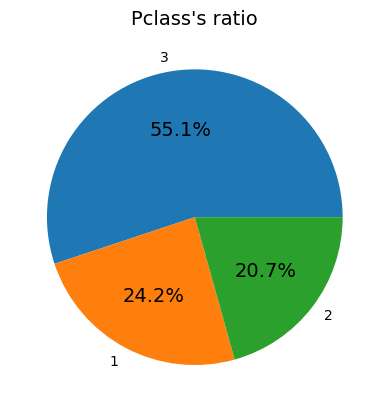

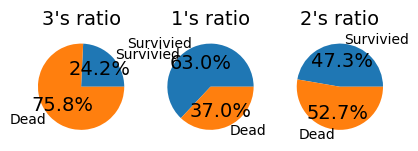

In [473]:
ratio = train_data['Pclass'].value_counts(sort=False)
labels = ratio.size
survived = train_data[train_data['Survived']==1]['Pclass'].value_counts()
dead = train_data[train_data['Survived']==0]['Pclass'].value_counts()

plt.plot(aspect='auto')
plt.pie(ratio, labels=ratio.index, autopct='%1.1f%%')
plt.title('Pclass' + '\'s ratio')
plt.show()

for i, index in enumerate(ratio.index):
    plt.subplot(1, ratio.size + 1, i + 1, aspect='equal')
    plt.pie([survived[index], dead[index]], labels=['Survivied', 'Dead'], autopct='%1.1f%%')
    plt.title(str(index) + '\'s ratio')

plt.show()

`Pclass`는 사회 경제적 지위로, 숫자가 작을수록 높은 사회 경제적 지위를 가지고 있다는 뜻이다.

사회 경제적 지위가 높으면 생존률도 높았다는 것을 볼 수 있다.

#### 범주형 특성 간의 상관관계


위에서 범주형 특성을 제외시켰기 때문에 남은 범주형 특성은

- Sex

- Embarked

이다.

- 성별에 따른 생존률을 알아보자.

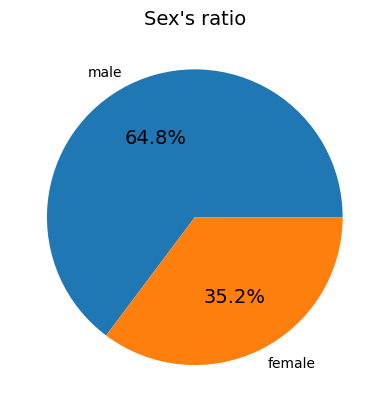

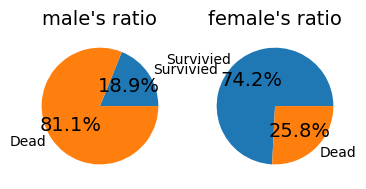

In [474]:
ratio = train_data['Sex'].value_counts(sort=False)
labels = ratio.size
survived = train_data[train_data['Survived']==1]['Sex'].value_counts()
dead = train_data[train_data['Survived']==0]['Sex'].value_counts()

plt.plot(aspect='auto')
plt.pie(ratio, labels=ratio.index, autopct='%1.1f%%')
plt.title('Sex' + '\'s ratio')
plt.show()

for i, index in enumerate(ratio.index):
    plt.subplot(1, ratio.size + 1, i + 1, aspect='equal')
    plt.pie([survived[index], dead[index]], labels=['Survivied', 'Dead'], autopct='%1.1f%%')
    plt.title(str(index) + '\'s ratio')

plt.show()

남자의 비율이 여자보다 많았고, 여자의 생존률이 남자의 생존률보다 높았던 것을 알 수 있다.

- 탑승 장소에 따른 생존률을 알아보자.

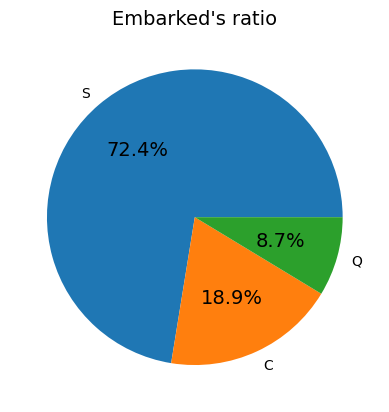

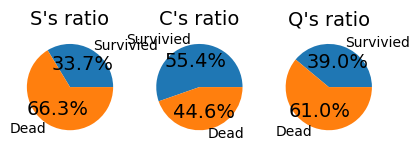

In [475]:
ratio = train_data['Embarked'].value_counts(sort=False)
labels = ratio.size
survived = train_data[train_data['Survived']==1]['Embarked'].value_counts()
dead = train_data[train_data['Survived']==0]['Embarked'].value_counts()

plt.plot(aspect='auto')
plt.pie(ratio, labels=ratio.index, autopct='%1.1f%%')
plt.title('Embarked' + '\'s ratio')
plt.show()

for i, index in enumerate(ratio.index):
    plt.subplot(1, ratio.size + 1, i + 1, aspect='equal')
    plt.pie([survived[index], dead[index]], labels=['Survivied', 'Dead'], autopct='%1.1f%%')
    plt.title(str(index) + '\'s ratio')

plt.show()

`Southampthon`에서 탑승한 사람이 많았고, `Cherbourg`에서 탑승한 사람의 생존률이 가장 높은 것을 알 수 있다.

- `Pclass`, `Sex`, `Embarked` 세 특성간 상관관계를 알아보자.

In [ ]:
f, ax = plt.subplots(ncols=3, figsize=(20, 8))

sns.barplot(data=train_data, x="Pclass", y="Survived", hue="Sex", ax=ax[0])       # 사회적 지위별 성별의 생존률
sns.barplot(data=train_data, x="Embarked", y="Survived", hue='Sex', ax=ax[1])     # 탑승 장소별 성별의 생존률
sns.barplot(data=train_data, x="Embarked", y="Survived", hue='Pclass', ax=ax[2])  # 탑승 장소별 사회적 지위의 생존률
plt.show()

## 전처리

### 결측치 찾기

In [ ]:
train_data.isnull().sum()

`Age` 특성에 있는 결측치를 채워보자.(어차피 사용하지 않을 특성이지만 채워보자.)

결측치를 처리하는 방법에는 세 가지 방법이 있다.

1. 누락치 특성 포함 샘플 삭제
2. 누락치를 포함한 특성 삭제
3. 누락치를 해당 특성의 중앙값/평균값 등으로 대체

여기서는 중앙값으로 대체해보자.

In [ ]:
median = train_data['Age'].median()
train_data['Age'].fillna(median, inplace=True)

In [ ]:
train_data.isnull().sum()

`Age` 특성에 결측치가 사라진 것을 볼 수 있다.

`Embarked` 특성에도 결측치가 2개 있다. 이때 단순히 가장 많이 탑승한 항구인 `Southampton`으로 가정해보자.

In [ ]:
train_data['Embarked'].fillna('S', inplace=True)

In [ ]:
train_data.isnull().sum()

결측치가 사라진 모습을 볼 수 있다.

### 특성 추출

사용하지 않을 특성은 `train_data`에서 빼주자.

In [ ]:
drop_features = ['Name', 'Age', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'Fare']

train_data = train_data.drop(drop_features, axis=1)
test_data = test_data.drop(drop_features, axis=1)

train_data = train_data.drop('PassengerId', axis=1)

In [ ]:
train_data.head()

In [ ]:
test_data.head()

In [ ]:
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)

train_label = train_data['Survived']
train_df = train_data.drop('Survived', axis=1)
test_df = test_data.drop("PassengerId", axis=1).copy()

## 예측 모델 생성

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.utils import shuffle

In [ ]:
train_df, train_label = shuffle(train_df, train_label, random_state = 5)

In [ ]:
def train_and_test(model):
    model.fit(train_df, train_label)
    prediction = model.predict(test_df)
    accuracy = round(model.score(train_df, train_label)*100, 2)
    print(f'Accuracy: {accuracy}%')
    return prediction

In [ ]:
# Logistic Regression
log_pred = train_and_test(LogisticRegression())
# SVM
svm_pred = train_and_test(SVC())
#kNN
knn_pred_4 = train_and_test(KNeighborsClassifier(n_neighbors = 4))
# Random Forest
rf_pred = train_and_test(RandomForestClassifier(n_estimators=100))
# Navie Bayes
nb_pred = train_and_test(GaussianNB())

In [ ]:
submission = pd.DataFrame({
    "PassengerId": test_data["PassengerId"],
    "Survived": rf_pred
})

submission.to_csv('submission_rf.csv', index=False)